In [711]:
using Pkg

Pkg.activate("..")

using SymPy, DifferentialEquations, Plots, Optim
using Statistics, Distributions, LaTeXStrings, Random, StatsBase

# Introduction

In this notebook I will solve the mean-field model for equlibrial biomass and demonstrate its suitability as an approximation of Lotka-Volterra dynamics. 

# Solving the mean-field model

To solve the mean-field model we first define the vairables to be used:

In [712]:
#define vairables and thier avarge counterparts
x,ux = symbols("x,μ_x")
r,ur = symbols("r,μ_r")
k,uk = symbols("k,μ_k")
aii,uaii = symbols("a_{ii},μ_{a_{ii}}")
N, ua = symbols("N, μ_{a}")

#define mean-field to solve
f = r - aii*x - ua*ux

x_sol = SymPy.solve(f, x)[1]

r - μₓ⋅μ_{a}
────────────
   a_{ii}   

In [713]:
#take average
ux_f1 = subs(x_sol , r =>ur) - ux
ux_sol = SymPy.solve(ux_f1, ux)[1]

      μᵣ      
──────────────
a_{ii} + μ_{a}

In [714]:
x_sol_final = subs(x_sol, ux => ux_sol).simplify()

r⋅(a_{ii} + μ_{a}) - μᵣ⋅μ_{a}
─────────────────────────────
   a_{ii}⋅(a_{ii} + μ_{a})   

In [715]:
a = x_sol_final.args[1].args[1]
b = symbols("b")
c = x_sol_final.subs(a,b).expand().subs(b,a)

c.subs(aii, 1).simplify()

r⋅μ_{a} + r - μᵣ⋅μ_{a}
──────────────────────
      μ_{a} + 1       

which with some manual rearanging equilbirium biomass is given by: 

$$
C_i^* = K_i - \bar{K} \frac{\bar{a}(N-1) }{ 1 + \bar{a}(N-1)}
$$

## Feasibility

taking this the equation for biomass above we can obtain an expression for feasability by enforcing the condition:

$$
x > 0 \quad \text{for all} \quad i = 1,2,\dots, N
$$

which gives the expression

$$
\frac{K_i}{\bar{K}} > \frac{ \bar{a}(N-1) }{1 + \bar{a}(N-1)}
$$

Here I simulate randomly generated systems to show that this bound applies to the lottka-volterra system (if the assumptions of the mean-field are met). Note that I keep intraspecific interactions constant ($a_{ii} = 1$) to aid in the interpretation. 

In [716]:
Random.seed!(1)

function mean_no_diag(A)
    B = deepcopy(A)
    [B[i,i] = 0.0 for i = 1:size(A)[1]]
    sum(B) / (size(A)[1] * (size(A)[1]-1))
end

function dx!(dx,x,p,t)
    dx[:] .= 0.0
    for i = p.extant
        dx[i] = x[i] * p.r[i]
        for j = p.extant
            dx[i] -= x[i] * x[j] * p.a[i,j]  
        end 
    end    
end

#parameter structure
mutable struct Param
    N::Int64
    r::Vector{Float64}
    a::Array{Float64,2}
    extant::Vector{Int64}
end

#analytical bound - ā is opposite sign 
function bound(N,ā) 
    (ā*(N-1)) / ( (ā*(N-1)) + 1 )
end

#generate random communtiy
function generate_parameters(N, a_μ, r_σ)
    r = rand(Distributions.LogNormal(1.0,r_σ), N)
    a = rand(Distributions.LogNormal( log(a_μ / N) , 0.5) ,N,N)
    [a[i,i] = 1.0 for i = 1:N]
    Param(N,r,a,collect(1:N))
end

#simulation parameters
N = 50
x0 = rand(N) * 0.1
tspan = (0, 1e3)

# #replicate parameters
N_a, N_r, N_rep = 20 , 20 , 2
a_vec = range(0.0, 1.0, length = N_a)
r_vec = range(0.0, 1.0, length = N_r)

# #results array
feas_results = Array{Tuple{Float64,Vector{Float64},Bool},3}(undef, N_a, N_r, N_rep)

for i = 1:N_a, j = 1:N_r, k = 1:N_rep
    p = generate_parameters(N,a_vec[i],r_vec[j])    
    prob = ODEProblem(dx!, x0  , tspan, p)
    sol = DifferentialEquations.solve(prob)
    
    #realised parameters
    a = mean_no_diag(p.a)
    r = p.r ./ mean(p.r)
    
    feas_results[i,j,k] = a,r, all(sol[end] .> eps())
end

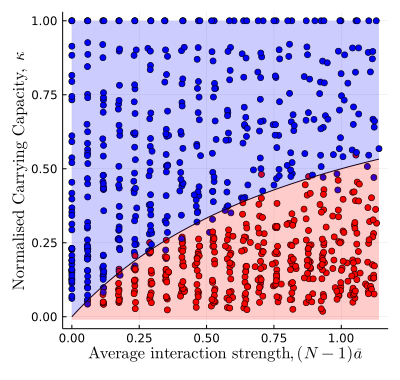

In [717]:
#plotting
#setup plotting arrays
x = [ feas_results[:][i][1] for i = 1:(N_a*N_r*N_rep) ]

y = [minimum(feas_results[:][i][2]) for i = 1:(N_a*N_r*N_rep)]
y = vcat(y...)

c = [all(feas_results[:][i][3]) for i = 1:(N_a*N_r*N_rep)]
c = vcat(c...)


col = fill(:red, N_a*N_r*N_rep)
col[c] .= :blue

p1 = scatter(x .* (N-1),y,color = col,
    ylab = L"\textrm{Normalised Carrying Capacity}, \ \kappa",
    xlab = L"\textrm{Average interaction strength},(N-1)\bar{a}")

xrange = range(minimum(x),maximum(x),length = 100)

plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "black", lw = 1, size = (400,380))
plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "Black", lw = 0, legend = false,fill = (-0.01,0.2,:red))
plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "Black", lw = 0, legend = false,fill = (1,0.2,:blue))
savefig(p1, "../docs/Figures/Fig_1.pdf")

p1

# Probability of Feasibility

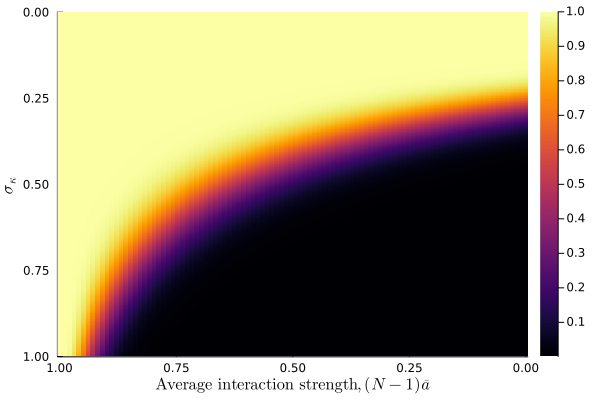

In [718]:
Random.seed!(1)

N = 50
# #replicate parameters
N_a, N_r = 100 , 500
a_vec = range(1.0, 0.0, length = N_a)
r_vec = range(0.0, 1.0, length = N_r)

res = Array{Float64,2}(undef, length(a_vec), length(r_vec) )

for i = eachindex(a_vec), j = eachindex(r_vec)
    dr = Distributions.LogNormal(-(r_vec[j]^2) / 2,  r_vec[j])
    da = Distributions.LogNormal( log(a_vec[i] / N) , 0.5)
    
    res[i,j] = (1-Distributions.cdf(dr, bound(N,mean(da))))^N
end


p2 = heatmap(reverse(a_vec),r_vec,res', yflip = true, xflip = true,
    xlab = L"\textrm{Average interaction strength},(N-1)\bar{a}",
    ylab = L"\sigma_{\kappa}")

# savefig(p2, "../docs/Figures/Fig_2.pdf")
# p2

# Temperature
So how can we include temperature in this?

We first observe that in the feasibility condidtion

In [719]:
#returns distribution given thermal-sensitvtiy traits and temperature
# all TPC trait moments are for normal versions
struct TpcParameters
    μK0::Float64
    σK0::Float64
    μEK::Float64
    σEK::Float64
    
    μa0::Float64
    σa0::Float64
    μEa::Float64
    σEa::Float64
end

#get T-dependent parameters

#kappa distribution
function get_dK(Temp,p::TpcParameters)
    μK = p.μK0 - p.μEK*Temp
    σK = p.σK0^2 + (p.σEK^2 * Temp^2)
    
    return(Distributions.LogNormal(μK,σK))
end

function get_dκ(Temp,p::TpcParameters)
    dK = get_dK(Temp,p::TpcParameters)
    return(Distributions.LogNormal(-dK.σ^2 / 2 ,dK.σ))
end

#a distribution
function get_ā(Temp, p::TpcParameters)
    μa = p.μa0 - p.μEa * Temp
    σa = p.σa0^2 + (p.σEa^2 * Temp^2)
    
    da = Distributions.LogNormal(μa,σa)
    return(mean(da))
end

get_ā (generic function with 1 method)

First lets look at the components that make up the TPC for species richness

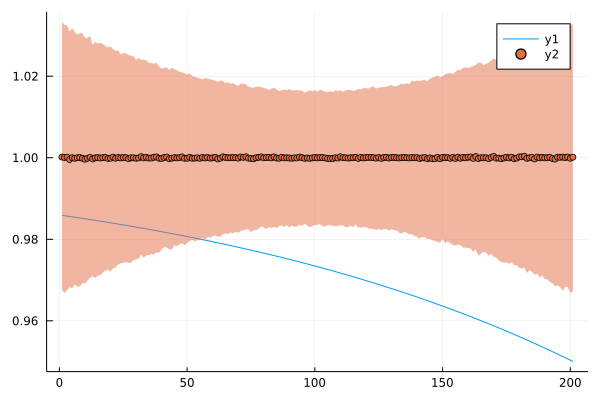

In [720]:
μK0, μEK, σK0, σEK =  0.0, 0.65, 0.1, 0.1
μa0, μEa, σa0, σEa = -1.0, 0.65, 0.1, 0.1
p_TPC = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)

N = 100

#T_Vec
T_vec = -1:0.01:1.0

ā_T = get_ā.(T_vec, Ref(p_TPC))
θ_T = plot(bound.(N,ā_T))
rand_κ_T = rand.(get_dκ.(T_vec, Ref(p_TPC)), 10000)
#bounds on κ
mean_κ_T = mean.(rand_κ_T)
u_κ_T = abs.(mean_κ_T .- quantile.(rand_κ_T,0.95))
l_κ_T = abs.(mean_κ_T .- quantile.(rand_κ_T,0.05))

scatter!(mean_κ_T, ribbon = (u_κ_T,l_κ_T))

In [721]:
#calculate p_feas
function p_feas(Temp,N,p::TpcParameters)
    #get ā
    ā = get_ā(Temp, p)
    dK = get_dK(Temp,p)
    dκ = Distributions.LogNormal(-dK.σ^2 / 2 ,dK.σ)
    
    #calculate bound
    bound = (ā*(N-1)) / ( (ā*(N-1)) + 1)
    
    #calcualte P_feas
    (1 - cdf(dκ, bound))^N
end

function get_N(Temp, θ, p::TpcParameters)
    #function to optimise
    f(x) = abs(p_feas(Temp, x, p) .- θ)
    findmin(f.(1:1000))[2]
end


get_N (generic function with 1 method)

The red shaded area is 95% quanitle bound for $\kappa$ and the blue line the bound imposed by species interactions. Overall se see that at different temperatures the system can be feasable (red bound is above the blue line) or unfeasible (red bound bellow blue line). Another way to visualise this is to directly plot the probability distribuon of $\kappa$ as a heatmap

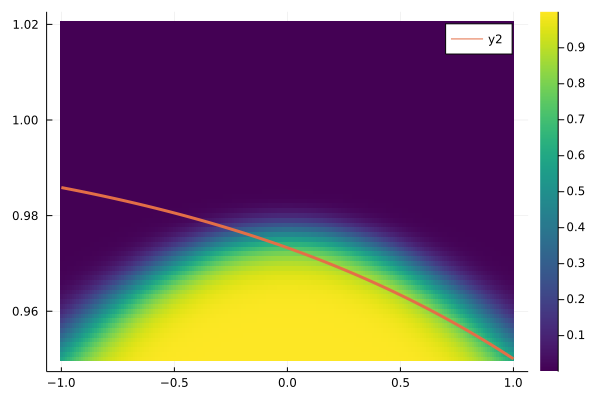

In [722]:
p_vec = 0.95:0.001:1.02
dκ_T = get_dκ.(T_vec, Ref(p_TPC))
N = 100

heatmap(T_vec, p_vec, hcat([1 .- cdf.(d, p_vec) for d = dκ_T]...).^ N, color = :viridis)
θ_T = plot!(T_vec, bound.(N,ā_T), lw = 3)


This shows the probabilty that $\kappa$ is greater than the probability value on the y axis across temperature and all $N$ species in the system. Above we see that the system is not feasable at the extreams of temperature but in the middle $\kappa$ is almost garanted to be greater than the bound in red. Next we consider the effect of changing $N$. 

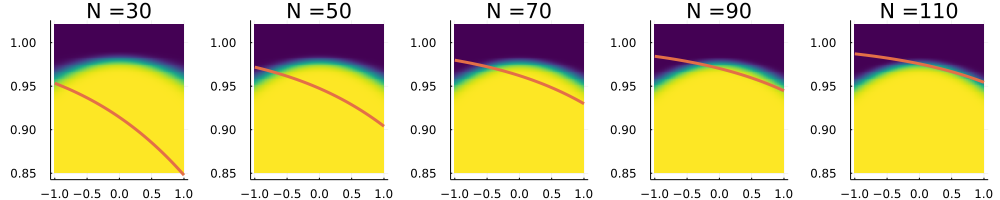

In [723]:
N_vec = [30,50,70,90,110]
p_vec = 0.85:0.001:1.02

p = [heatmap(T_vec, p_vec, hcat([1 .- cdf.(d, p_vec) for d = dκ_T]...).^ N_vec[i], color = :viridis) for i = eachindex(N_vec)] 
[plot!(p[i], T_vec, bound.(N_vec[i],ā_T), lw = 3, colorbar = false, legend = false) for i = eachindex(N_vec)]
[title!(p[i],string("N =",N_vec[i])) for i = eachindex(N_vec)]
plot(p..., layout = (1,5), size = (1000,200), link = :y)

From this we see that as $N$ increases the it becomes less likely that $\kappa$ will be greater than the bound and thus the system be feasible. The quest then arrises what is the maximum $N$ value that a system can have whilst $\kappa$ remains above the bound? We first consider a single temperature. 

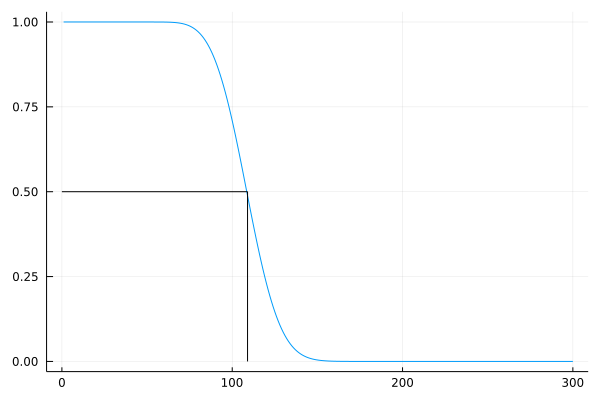

In [724]:
function p_feas(Temp,N,p::TpcParameters)
    #get ā
    ā = get_ā(Temp, p)
    dκ = get_dκ(Temp,p)
    
    #calculate bound
    bound = (ā*(N-1)) / ( (ā*(N-1)) + 1)
    
    #calcualte P_feas
    (1 - cdf(dκ, bound))^N
end



N_vec = collect(1:300)
p_feas_vec = p_feas.(0.0, N_vec, Ref(p_TPC))

threshold = 0.5
threshold_indx = findmin(abs.(p_feas_vec .- threshold))[2]
N_threshold = N_vec[threshold_indx]


plot(N_vec, (p_feas_vec), legend = false)
plot!([N_threshold,N_threshold],[threshold,0],c = "black")
plot!([0,N_threshold],[threshold,threshold], c = "black")

We can see here as expected the probability of feasiblity goes down as the number of species goes up! Thus all we need to do to determine the exact number of species is choose a threshold probabiltiy ($0.1$ here). This is represented by the black lines showing the probability and corresponding richness. Next we look at this across temperature. 

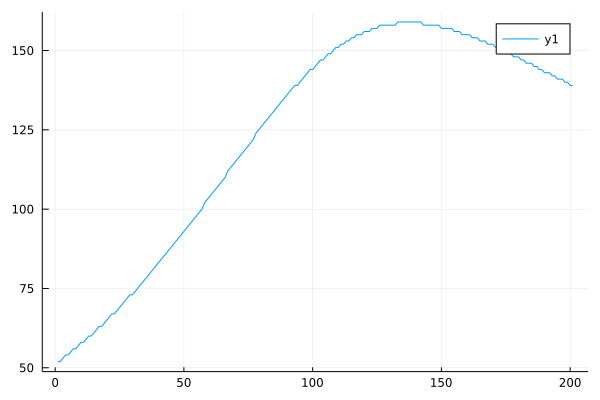

In [725]:
function get_N(Temp,threshold,p::TpcParameters)
    prob = p_feas.(Temp,1:1000,Ref(p))
    x = findmin(abs.(prob .- threshold))[2]
    return(x)
end

plot(get_N.(T_vec,0.01 ,Ref(p_TPC)))

# Species richness

Next we apply this to see the overall effect of changing parameters of the thermal sensitvitiy distributions. 

In [726]:
using DelimitedFiles

param_table = readdlm("../data/K_TPC_output.csv", ',')

keys = string.(param_table[:,1],"_",param_table[:,2])

obs_param = Dict(keys[i] => param_table[i, 3] for i = 2:5)

Dict{String, Float64} with 4 entries:
  "mean_K0"  => -0.144021
  "sd_E_K"   => 0.287376
  "mean_E_K" => 0.0565693
  "sd_K0"    => 0.575403

In [740]:
#results
μK0, μEK, σK0, σEK = obs_param["mean_K0"], abs(obs_param["mean_E_K"]), obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0 = log(0.01), 0.5

NE,N_Temp = 3, 25

#generate E ranges
μEa_vec = range(-0.65,0.65,length = NE)
σEa_vec = range(0.0,1.0,length = NE)

T_vec = range(-1,1, length = N_Temp)

#plots
res_a = Array{Float64, 3}(undef, NE, NE, N_Temp)

for i = eachindex(μEa_vec)
    for j = eachindex(σEa_vec)
        #define params
        p = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa_vec[i], σEa_vec[j])
        #get N
        K = ΔTtoK.(T_vec,293.15)
        res_a[i,j,:] = get_N.(T_vec, 0.01, Ref(p))
        
    end
end

writedlm("HelperScripts/Data/Non_assembly/sp_num_a_sig_0.0.csv",res_a[:,1,:]',',')
writedlm("HelperScripts/Data/Non_assembly/sp_num_a_sig_0.5.csv",res_a[:,2,:]',',')
writedlm("HelperScripts/Data/Non_assembly/sp_num_a_sig_1.0.csv",res_a[:,3,:]',',')

In [741]:
#for K
μK0, μEK, σK0, σEK = obs_param["mean_K0"], abs(obs_param["mean_E_K"]), obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0, μEa, σEa = log(0.01), 0.5, 0.65, 0.2

#generate E ranges
σEK_vec = range(0.0,0.5,length = 3)
res_k = Array{Float64, 2}(undef, NE, N_Temp)

for i = eachindex(σEK_vec)
    #define params
    p = TpcParameters(μK0, σK0, μEa, σEK_vec[i], μa0, σa0, μEa, σEa)

    #get N    
    N = get_N.(T_vec, 0.01, Ref(p))
    K = ΔTtoK.(T_vec,293.15)
    res_k[i,:] .= N
end
 
writedlm("HelperScripts/Data/Non_assembly/sp_num_k.csv",res_k',',')

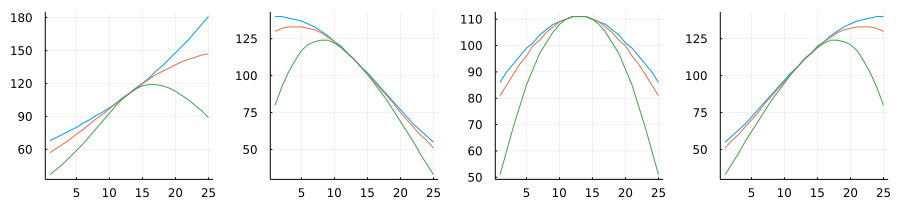

In [737]:
p = [plot(res_a[i,:,:]') for i = 1:3]
plot(plot(res_k'), p..., layout = (1,4), size = (900,200), legend = false)

In [739]:
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0, μEa, σEa = log(0.01), 0.5, -0.65, obs_param["sd_E_K"]
p_var = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)

μEK = 0.65; σEK = 0.0
μEa = -0.65; σEa = 0.0
p_MTE = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)

#get N

res_MTE = get_N.(T_vec, 0.8, Ref(p_MTE))
res_var = get_N.(T_vec, 0.8, Ref(p_var))

writedlm("HelperScripts/Data/Non_assembly/sp_num_MTE.csv",[res_MTE res_var],',')

# Numerical simulations
The question that arrises is can we use this to predict richness in real communities? To do we look at the assembly of GLV systems using distributions of TPC parameters to draw new species. First however we look at a single system initialised with 100 random species.

In [731]:
#make simulation params from TPC params
function generate_parameters_fromTPC(N, ΔT, p::TpcParameters)
    
    r0 = rand(Distributions.Normal(p.μK0, p.σK0), N)
    rE = rand(Distributions.Normal(p.μEK, p.σEK), N)
    
    r = exp.(r0) .* exp.(-rE .* ΔT)
    
    a0 = rand(Distributions.Normal(p.μa0, p.σa0), N, N)
    aE = rand(Distributions.Normal(p.μEa, p.σEa), N, N)
    
    a = exp.(a0) .* exp.(-aE .* ΔT)
    [a[i,i] = 1.0 for i = 1:N]
    
    Param_(N,r,a,collect(1:N))
end
        
#callbacks - detect extinction
function condition2(u,t,integrator)
    any(u[integrator.p.extant] .< eps())
end

#remove sp from extant list (dont itterate over)
function affect!(integrator)
   deleteat!(integrator.p.extant, in.(integrator.p.extant, Ref(findall(integrator.u .< eps()))))  
end
    
cb = DiscreteCallback(condition2, affect!; save_positions = (false, false))
ss_cb = TerminateSteadyState()
cb_set = CallbackSet(cb,ss_cb);
    

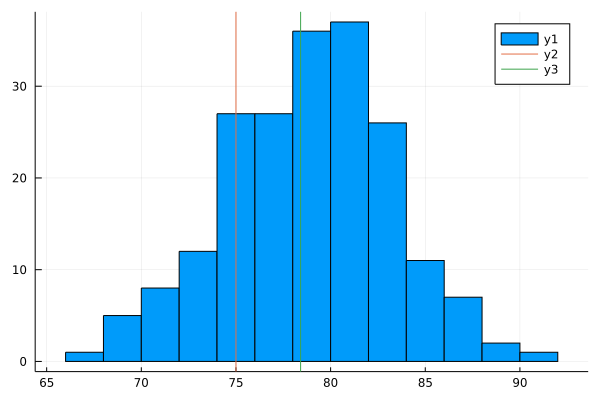

In [675]:
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0, μEa, σEa = log(0.01), 0.5, -0.65, obs_param["sd_E_K"]
p_var = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)

N = 100
N_rep = 200
x0 = ones(N)
tspan = (0.0, 1e6)

N_res = zeros(N_rep)
for i = eachindex(N_res)
    print(i, "\r")
    p_TPC = generate_parameters_fromTPC(N, 0.0, p_var)

    prob = ODEProblem(dx!, x0, tspan, p_TPC)
    sol = DiffEqBase.solve(prob, save_at = tspan[end], callback = cb_set)
    N_res[i] = sum(sol[end] .> eps())
end

histogram(N_res)    
vline!([get_N(0.0,0.5,(p_var))])
vline!([mean(N_res)])


We can see that for a single temperature the average number of species reached is arround the correct value.  Next we look at the assembled scenario. 

In [676]:
#Functions to generate random parameters
function rand_r(p::TpcParameters, ΔT, N...)
    r0 = rand(Distributions.Normal(p.μK0, p.σK0), N)
    rE = rand(Distributions.Normal(p.μEK, p.σEK), N)
    return(exp.(r0) .* exp.(-rE .* ΔT))
end
    
function rand_a(p::TpcParameters, ΔT, N...)
    a0 = rand(Distributions.Normal(p.μa0, p.σa0), N)
    aE = rand(Distributions.Normal(p.μEa, p.σEa), N)
    return(exp.(a0) .* exp.(-aE .* ΔT))
end
 
#assembly loop
function assembly_simulate(N_start, p , ΔT, n_obs)
    tspan = (0.0,1e10)
    #starting biomass
    x0 = ones(N_start)
    #get starting params
    p_T = generate_parameters_fromTPC(N_start, ΔT, p)
    #store results
    res = []
    push!(res, [1, 0.0])
    #to determine stabiltiy of N
    coef_var_N = collect(1:n_obs)
    assembling = true
    
    while assembling
        prob = ODEProblem(dx!, x0, tspan, p_T)
        sol = DiffEqBase.solve(prob, saveat = [tspan[end]], callback = cb_set)

        #update N
        p_T.N += 1
        #update r
        append!(p_T.r, rand_r(p, ΔT, 1))     
        
        #update a
        a_new = rand_a(p, ΔT, p_T.N, p_T.N)
        a_new[1:(p_T.N-1) , 1:(p_T.N-1)] .= p_T.a
        a_new[p_T.N,p_T.N] = 1
        p_T.a = a_new
        
        #update extant
        append!(p_T.extant,p_T.N)
        #updatebiomass
        x0 = sol[end]
        append!(x0, 0.01)

        #save result
        push!(res, [sum(x0 .> eps()), sol.t[1]])
        
        #shift and add new N to coef_var_N
        coef_var_N = circshift(coef_var_N, 1)
        coef_var_N[1] = sum(x0 .> eps())   
                        
        if (std(coef_var_N)/mean(coef_var_N)) < 0.05 || sol.retcode == :unstable
             assembling = false
        end
    end

    return res
end    

assembly_simulate (generic function with 2 methods)

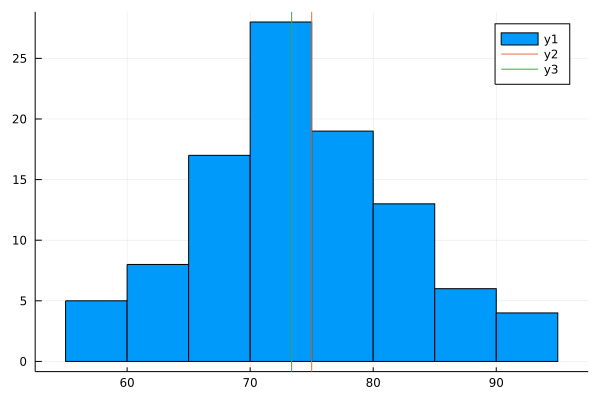

In [583]:
N_rep = 100
N_res = zeros(N_rep)

for i = eachindex(N_res)
    print(i, "\r")
    N_res[i] = assembly_simulate(1, p_var, 0.0, 20)[end][1]
end

histogram(N_res)    
vline!([get_N(0.0,0.5,(p_var))])
vline!([mean(N_res)])

Which again looks pretty good. Next we simulate across temperatures

In [678]:
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0, μEa, σEa = log(0.02), 0.5, -0.65, obs_param["sd_E_K"]
p_var = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)


N_rep = 10
N_Temp = 10

T_vec = range(-1,1,length=N_Temp)

N_res = zeros(N_rep,N_Temp)

for i = 1:(N_rep)
    for j = 1:(N_Temp)
        print(i," ",j, "\r")
        N_res[i,j] = assembly_simulate(1, p_var, T_vec[j], 20)[end][1]
    end
end


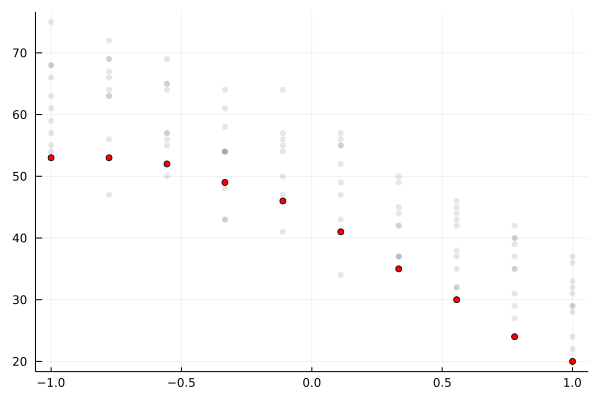

In [679]:
pred = get_N.(T_vec,0.5,Ref(p_var))

scatter(T_vec,N_res', c = "black", alpha = 0.1, legend = false)
scatter!(T_vec,pred, c = "red", alpha = 1.0, legend = false)

The plot above shows how the predicted richness matches the obserations from assembled systems fairly well. Then we move on to testing different levels of variation in $E$

In [680]:
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], 0.0
μa0, σa0, μEa, σEa = log(0.02), 0.5, -0.65, 0.0

N_rep = 20
N_Temp = 20
σ_E = [0.0, 0.25, 0.5]


T_vec = range(-1,1,length=N_Temp)
N_res = Array{Any,3}(undef, 3,N_rep,N_Temp)

for i = 1:3
    p_var = TpcParameters(μK0, σK0, μEK, σ_E[i], μa0, σa0, μEa, σ_E[i])
    for j = 1:N_rep
        for k = 1:N_Temp
            print(i," ",j," ",k,"\r")
            N_res[i,j,k] = assembly_simulate(1, p_var, T_vec[k], 50)
        end
    end
end

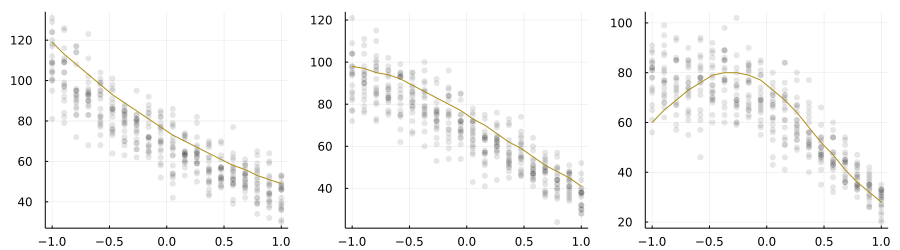

In [691]:
p_var_vec = TpcParameters.(μK0, σK0, μEK, σ_E, μa0, σa0, μEa, σ_E)
real = map(x -> x[end][1], N_res)
pred = hcat([get_N.(T_vec, 0.001, Ref(p_var_vec[i])) for i = 1:3]...)


f_p(x) = (x)

p = [scatter(T_vec, f_p.(real[i,:,:]'), c = "black", alpha = 0.1, legend = false) for i = 1:3]
[plot!(p[i],T_vec,f_p.(pred[:,i])) for i = 1:3]

    
plot(p..., layout = (1,3), size = (900,250))

In [699]:
#save data
#N_end
[writedlm(string("HelperScripts/Data/Assembly/N_end_",i,".csv"),real[i,:,:],',') for i = 1:3]
writedlm("HelperScripts/Data/Assembly/Temp.csv",T_vec,",")

#predictions upper + lower
writedlm("HelperScripts/Data/Assembly/pred.csv", pred_u, ",")

#Ntime
N_sig_2 = map(x -> hcat(x...)',N_res[2,:,:])
for i = 1:20
    for j = 1:20
        file = string("HelperScripts/Data/Assembly/N_time/N_time_rep_",i,"_temp_",T_vec[j],".csv")
        writedlm(file, N_sig_2[i,j],",")
    end
end
